In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot
import copy
from itertools import combinations
from scipy.special import factorial, comb
from IPython.display import display, HTML
from datetime import date, timedelta
from typing import List
from collections.abc import Callable
from pprint import pprint
from scipy import stats
from scipy.stats import shapiro

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

conf = SparkConf()
conf.setMaster('yarn')
conf.setAppName('hive_sql_query')

# set cluster name and queue that you have permission to access
conf.set("spark.hadoop.yarn.cluster.name", "default")
conf.set("spark.yarn.queue", "root.mouse_tiktok_ug_data")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

Duplicate key in file PosixPath('/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 767 ('font.family  : sans-serif')
Duplicate key in file PosixPath('/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 768 ('font.sans-serif : SimHei, DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 769 ('axes.unicode_minus : False')


In [4]:
start_date = '20211201'
end_date = '20211214'

In [5]:
# sql for raw data
sql = """
with user_list as 
(
    select 
        device_id
    from ug_dw_int.dw_ug_device_retention_daily
    where date = '{start_date}'
    and is_active = 1
    and app_id in (1180, 1233, 1339, 1340)
    limit 100000
),
user_vv as 
(
    select 
        device_id,
        sum(is_active) as active_day,
        sum(vv) as sum_vv
    from ug_dw_int.dw_ug_device_retention_daily
    where date between '{start_date}' and '{end_date}'
    and app_id in (1180, 1233, 1339, 1340)
    group by 
        device_id
)

select 
    ul.device_id,
    active_day,
    sum_vv
from user_list ul 
left join user_vv uv on ul.device_id = uv.device_id
"""

In [6]:
sql_w_param = sql.format(**{'start_date': start_date, 'end_date': end_date})
# run spark sql
df_raw_spark = spark.sql(sql_w_param)
# create pandas df
df_raw = df_raw_spark.toPandas()

In [7]:
df_raw.head()

,device_id,active_day,sum_vv
0,6749075313764369926,13,5250
1,6749078303405278726,14,4651
2,6749128076226381313,14,6433
3,6749148190337828358,14,2253
4,6749165924533700101,5,724


In [8]:
df = df_raw
df['vv_per_active_day'] = df['sum_vv'] / df['active_day']

df.head()

,device_id,active_day,sum_vv,vv_per_active_day
0,6749075313764369926,13,5250,403.846154
1,6749078303405278726,14,4651,332.214286
2,6749128076226381313,14,6433,459.500000
3,6749148190337828358,14,2253,160.928571
4,6749165924533700101,5,724,144.800000


In [9]:
# matplotlib.pyplot.hist(df['vv_per_active_day'].to_numpy())

In [10]:
# matplotlib.pyplot.hist(df['sum_vv'].to_numpy())

0.8314646482467651


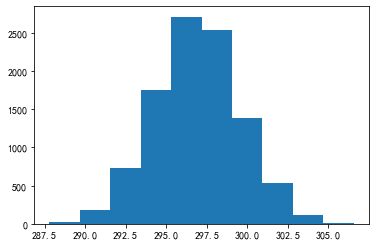

In [22]:
to_be_test = df.vv_per_active_day

sample_time = 10000

sample_mean_list = [None] * sample_time

for i in range(sample_time):
    random_sample = np.random.choice(to_be_test, 10000 , replace = True)
    sample_mean = random_sample.mean()
    sample_mean_list[i] = sample_mean

matplotlib.pyplot.hist(sample_mean_list)

stat, p = shapiro(sample_mean_list)

print(p)

0.7361829280853271


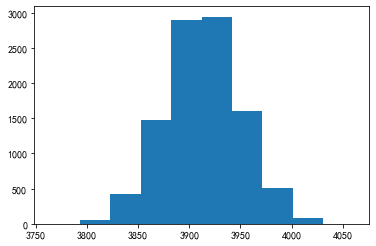

In [23]:
to_be_test = df.sum_vv

sample_time = 10000

sample_mean_list = [None] * sample_time

for i in range(sample_time):
    random_sample = np.random.choice(to_be_test, 10000 , replace = True)
    sample_mean = random_sample.mean()
    sample_mean_list[i] = sample_mean

matplotlib.pyplot.hist(sample_mean_list)

stat, p = shapiro(sample_mean_list)

print(p)

In [11]:
stat, p = shapiro(df.vv_per_active_day)

print(p)

0.0


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [5]:
stats.chisquare([ 951626 , 953453]) 

Power_divergenceResult(statistic=1.7521210406497578, pvalue=0.18561031006034256)